# Collaborative Filtering

Collaborative Filtering simply put uses the "wisdom of the crowd" to recommend items. Item based collaborative filtering uses the patterns of users who liked the same movie as me to recommend me a movie (users who liked the movie that I like, also liked these other movies).  Recommendation based on user's input of any movie present in the dataset is done. 


In [2]:
!wget -O data/ml-100k.zip http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -o data/ml-100k.zip -d data


--2019-12-11 06:03:48--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘data/ml-100k.zip’

data/ml-100k.zip    100%[===================>]   4.70M  18.4MB/s    in 0.3s    

2019-12-11 06:03:48 (18.4 MB/s) - ‘data/ml-100k.zip’ saved [4924029/4924029]

Archive:  data/ml-100k.zip
  inflating: data/ml-100k/allbut.pl  
  inflating: data/ml-100k/mku.sh     
  inflating: data/ml-100k/README     
  inflating: data/ml-100k/u.data     
  inflating: data/ml-100k/u.genre    
  inflating: data/ml-100k/u.info     
  inflating: data/ml-100k/u.item     
  inflating: data/ml-100k/u.occupation  
  inflating: data/ml-100k/u.user     
  inflating: data/ml-100k/u1.base    
  inflating: data/ml-100k/u1.test    
  inflating: data/ml-100k/u2.bas

In [44]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation

%matplotlib inline

from subprocess import check_output
print(check_output(["ls", "data"]).decode("utf8"))


ml-100k
ml-100k.zip
test
train



In [175]:
import copy
import random
import numpy as np

def shuffle(data):
    ret = copy.deepcopy(data)
    random.shuffle(ret)
    
    return ret

def data_split(data, ratio=0.2):
    tmp = copy.deepcopy(data)
    len_up = int(round(len(tmp) * ratio, 0))
    len_down = len(tmp) - len_up

    idx = np.random.randint(len(tmp), size=len_up)
    data_up = tmp[idx,:]
    tmp = np.delete(tmp, idx, 0)

    data_down = tmp
    
    return data_up, data_down
    

In [164]:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('data/ml-100k/u.user', sep='|', names=u_cols,
                    encoding='latin-1', parse_dates=True) 

users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [165]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('data/ml-100k/u.data', sep='\t', names=r_cols,
                      encoding='latin-1')

ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [166]:
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('data/ml-100k/u.item', sep='|', names=m_cols, usecols=range(5),
                     encoding='latin-1')

movies.head()

,movie_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)


In [167]:
movie_ratings = pd.merge(movies, ratings)
df = pd.merge(movie_ratings, users)

df.head()

,movie_id,title,release_date,video_release_date,imdb_url,user_id,rating,unix_timestamp,age,sex,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),308,4,887739608,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,308,4,887738847,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),308,5,887736696,60,M,retired,95076


# Data Pre-Processing

In [168]:
df.drop(df.columns[[3,4,7]], axis=1, inplace=True)
ratings.drop( "unix_timestamp", inplace = True, axis = 1 ) 
movies.drop(movies.columns[[3,4]], inplace = True, axis = 1 )
#Dropping all the columns that are not really needed
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 9 columns):
movie_id        100000 non-null int64
title           100000 non-null object
release_date    99991 non-null object
user_id         100000 non-null int64
rating          100000 non-null int64
age             100000 non-null int64
sex             100000 non-null object
occupation      100000 non-null object
zip_code        100000 non-null object
dtypes: int64(4), object(5)
memory usage: 7.6+ MB


In [169]:
df.head()

,movie_id,title,release_date,user_id,rating,age,sex,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,308,4,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,308,5,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,308,4,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,308,4,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,308,5,60,M,retired,95076


# Movie Ratings

In [170]:
movie_stats = df.groupby('title').agg({'rating': [np.size, np.mean]})
movie_stats.head()


rating          
                            size      mean
title                                     
'Til There Was You (1997)      9  2.333333
1-900 (1994)                   5  2.600000
101 Dalmatians (1996)        109  2.908257
12 Angry Men (1957)          125  4.344000
187 (1997)                    41  3.024390

Setting a threshold of atleast 50 ratings for better analysis.

In [171]:
min_50 = movie_stats['rating']['size'] >= 50
movie_stats[min_50].sort_values([('rating', 'mean')], ascending=False).head()


rating          
                                                     size      mean
title                                                              
Close Shave, A (1995)                                 112  4.491071
Schindler's List (1993)                               298  4.466443
Wrong Trousers, The (1993)                            118  4.466102
Casablanca (1942)                                     243  4.456790
Wallace & Gromit: The Best of Aardman Animation...     67  4.447761

Much better. Mean ratings now look reliable. 

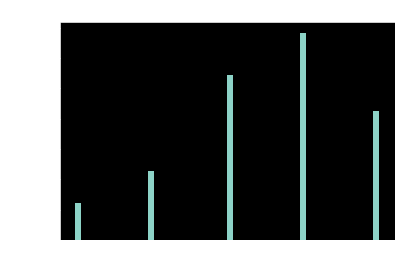

In [172]:
ratings.rating.plot.hist(bins=50)
plt.title("Distribution of Users' Ratings")
plt.ylabel('Number of Ratings')
plt.xlabel('Rating (Out of 5)');



# Raters' Age Distribution

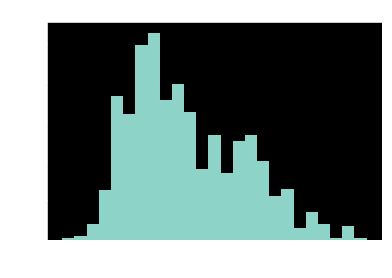

In [173]:
users.age.plot.hist(bins=25)
plt.title("Distribution of Users' Ages")
plt.ylabel('Number of Users')
plt.xlabel('Age');


# Pivot Table

In [180]:
test, train = data_split(ratings.values, 0.1)
print(train.shape, test.shape)

(90499, 3) (10000, 3)


In [181]:
df = pd.DataFrame(train, columns=['user_id', 'movie_id', 'rating'])
ratings_matrix = df.pivot_table(index=['movie_id'],columns=['user_id'],values='rating').reset_index(drop=True)
ratings_matrix.fillna( 0, inplace = True )
ratings_matrix.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
0,5.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,...,2.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
1,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,...,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [182]:
ratings_matrix.shape

(1669, 943)

# Cosine Similarity

In [187]:
movie_similarity = 1 - pairwise_distances( ratings_matrix.values, metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) #Filling diagonals with 0s for future use when sorting is done
df_movie_similarity = pd.DataFrame( movie_similarity )
df_movie_similarity.head(5)

In [188]:
df_movie_similarity.shape

(1669, 1669)

# Recommender Engine

In [193]:
try:
    #user_inp=input('Enter the reference movie title based on which recommendations are to be made: ')
    user_inp="Speed (1994)"
    inp=movies[movies['title']==user_inp].index.tolist()
    inp=inp[0]
    
except:
    print("Sorry, the movie is not in the database!")
    
movies['similarity'] = df_movie_similarity.iloc[inp]
movies.columns = ['movie_id', 'title', 'release_date','similarity']
movies.head()


,movie_id,title,release_date,similarity
0,1,Toy Story (1995),01-Jan-1995,0.959351
1,2,GoldenEye (1995),01-Jan-1995,0.966228
2,3,Four Rooms (1995),01-Jan-1995,0.911858
3,4,Get Shorty (1995),01-Jan-1995,0.969269
4,5,Copycat (1995),01-Jan-1995,0.932949


In [194]:
print("Recommended movies based on your choice of ",user_inp ,": \n", movies.sort_values( ["similarity"], ascending = False )[1:10])

Recommended movies based on your choice of  Speed (1994) : 
      movie_id                                      title release_date  \
160       161                             Top Gun (1986)  01-Jan-1986   
95         96          Terminator 2: Judgment Day (1991)  01-Jan-1991   
21         22                          Braveheart (1995)  16-Feb-1996   
209       210  Indiana Jones and the Last Crusade (1989)  01-Jan-1989   
384       385                           True Lies (1994)  01-Jan-1994   
171       172            Empire Strikes Back, The (1980)  01-Jan-1980   
94         95                             Aladdin (1992)  01-Jan-1992   
201       202                       Groundhog Day (1993)  01-Jan-1993   
78         79                       Fugitive, The (1993)  01-Jan-1993   

     similarity  
160    0.981741  
95     0.981682  
21     0.981650  
209    0.980936  
384    0.980222  
171    0.980177  
94     0.979183  
201    0.979003  
78     0.978705  


*This is my first try at recommender engines. Comments/suggestions are appreciated.*